## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

Ce note book contient : 
- Exploration des données

In [0]:
# init results table
df_results = None

## Installation libraries

In [0]:
#!pip install opencv-python && pip install opencv-contrib-python

!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not available
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-3.4.7.28:
  Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 74kB/s 
     |████████████████████████████████| 20.0MB 117kB/s 
ERROR: tensor2tensor 1.14.1 requires opencv-python, which is not installed.
ERROR: stable-baselines 2.2.1 requires opencv-python, which is not installed.
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: gym 0.15.4 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
  Found

### Keras

In [0]:
# if necessary, switch to TensorFlow 2.0 before occial relase on google colab : 
# %tensorflow_version 2.x

## Data mount drive folder

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [0]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
pwd: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [0]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

## Import

In [0]:
# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
#import sys
#sys.path.append('/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs')

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed


1.15.0


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images,
                path_train_list=None):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      #df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  

  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                  'Train'])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                     "Train"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  # check test/train mode
  if path_train_list is not None:
    print('Train/Test separation by mat')
    mat_train = sio.loadmat(path_data + path_train_list)
    df_train = pd.DataFrame(data=mat_train["file_list"], 
                           columns=["filename_brut"])
    df_train["filename"] = df_train["filename_brut"].apply(apply_find_filename)
    df_dogs["Train"] = df_dogs["filename"].apply(check_file_train, 
                                                 args=(df_train,))
  else:
    print('Train/Test separation by percent')
    df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

def check_file_train(filename, df_train):
  '''
  Apply function for dataFrame column to check Train file from data
  '''
  if filename in df_train["filename"].values:
    return True
  else:
    return False

def apply_find_filename(value):
  '''
  apply function for dataFrame column to extract filename from text

  example : 
    [n02085620-Chihuahua/n02085620_5927.jpg]	-> n02085620_5927.jpg
  '''
  return re.findall('(?<=/).+', value[0])[0]

def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      if df_dogs is not None:
        df_out = df_dogs
      else:
        print("Loading from disk df_dogs...")
        df_out = joblib.load(path_df_dogs)
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

def get_imagenet_classes():
  # get labels
  with open(path_imagenet) as json_data:
    class_idx = json.load(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    # PATCH : to correct double classes
    idx2label[idx2label.index("crane")] = "crane_0"
    idx2label[idx2label.index("maillot")] = "maillot_0"
  return idx2label

In [0]:
def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

In [0]:
def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

  def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

In [0]:
def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):
    '''
    Take scores from predictions
    V1.1 : 24/11/2019 : add acc test per breed
    '''
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred

    # find sort of breed name in Y classes (imagent) vs. X classes 
    # (selection of dogs)
    list_id=[]
    for id_y in np.unique(Y_test_num):
      for num_breed, breed_name in dict_breed.items():
        if breed_name == list_Y_classes[id_y]:
          list_id.append(num_breed)
    # add accuracy per breed
    K_id=0
    for id_class in np.unique(Y_test_num):
      str_dict_entry = "acc_test_{}B_{}".format(len(np.unique(Y_test_num)), list_id[K_id])
      dict_scores[str_dict_entry] = accuracy_score(
          Y_test_num[Y_test_num == id_class], 
          Y_test_pred_num[Y_test_num == id_class])
      K_id += 1
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

#### plot_history

In [0]:
def plot_history(history, my_title=None):
  # plot results at each iterations
  fig = plt.figure(figsize=(12, 8))
  if my_title is not None:
    fig.suptitle(my_title, fontsize=18)
  ax1 = fig.add_subplot(2,2,1)
  ax1.plot(range(0, len(history["acc"])), 
          history["acc"], 'o-')
  ax1.set_xlabel("epochs [-]")
  ax1.set_ylabel("accuracy [-]")
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_xlabel("epochs [-]")
  ax2.set_ylabel("acc test [-]")
  ax2.plot(range(0, len(history['val_acc'])), 
          history["val_acc"], 'ro-')
  ax3 = fig.add_subplot(2,2,3)
  ax3.set_xlabel("epochs [-]")
  ax3.set_ylabel("loss [-]")
  ax3.plot(range(0, len(history['loss'])), 
          history["loss"], 'o-')

  ax4 = fig.add_subplot(2,2,4)
  ax4.set_xlabel("epochs [-]")
  ax4.set_ylabel("val_loss [-]")
  ax4.plot(range(0, len(history['val_loss'])), 
          history["val_loss"], 'ro-')

## Loading

In [0]:
mat_contents = sio.loadmat(path_data + path_file_list)

In [0]:
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [0]:
mat_contents

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:29:09 2011',
 '__version__': '1.0',
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_9844'], dtype='<U44')],
        [array(['n02116738-African_hunting_dog/n02116738_9924'], dtype='<U44')]],
       dtype=object),
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],
        

In [0]:
np.unique(mat_contents['labels']).shape

(120,)

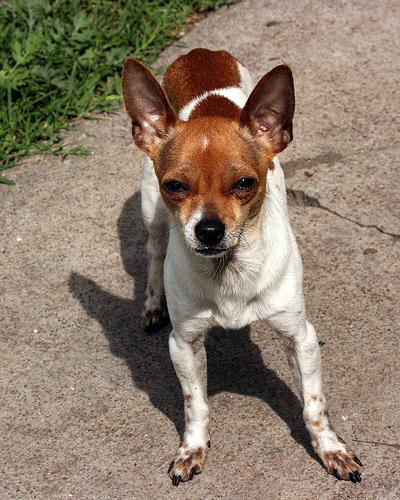

In [0]:
# test chargement image
# Charger l'image
img = Image.open(path_img_test) 


# Afficher l'image chargée
img

## Test image filters 

In [0]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 400 px, hauteur : 500 px


In [0]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : RGB
Valeur du pixel situé en (20,100) : (16, 28, 4)


In [0]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat_img = np.array(img)
mat_img



array([[[ 63,  57,  31],
        [ 84,  78,  54],
        [102,  96,  72],
        ...,
        [180, 158, 145],
        [183, 161, 148],
        [178, 156, 143]],

       [[ 86,  79,  53],
        [ 99,  93,  67],
        [112, 106,  82],
        ...,
        [177, 155, 142],
        [177, 155, 142],
        [171, 149, 136]],

       [[100,  93,  67],
        [105,  98,  72],
        [112, 105,  79],
        ...,
        [177, 155, 142],
        [175, 153, 140],
        [167, 145, 132]],

       ...,

       [[181, 163, 153],
        [183, 165, 155],
        [168, 150, 140],
        ...,
        [180, 160, 149],
        [176, 156, 145],
        [164, 144, 133]],

       [[162, 144, 134],
        [164, 146, 136],
        [159, 141, 131],
        ...,
        [201, 181, 170],
        [186, 166, 155],
        [161, 141, 130]],

       [[162, 144, 134],
        [171, 153, 143],
        [176, 158, 148],
        ...,
        [193, 173, 162],
        [163, 143, 132],
        [156, 136, 125]]

In [0]:
# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat_img.shape))

Taille de la matrice de pixels : (500, 400, 3)


In [0]:
mat_img_r = mat_img[0:,0:,0]
mat_img_g = mat_img[0:,0:,1]
mat_img_b = mat_img[0:,0:,2]

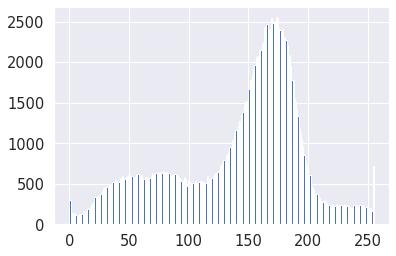

In [0]:
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(mat_img_r.flatten(), bins=range(256))
plt.show()

In [0]:
img_autocontrast = ImageOps.autocontrast(img)

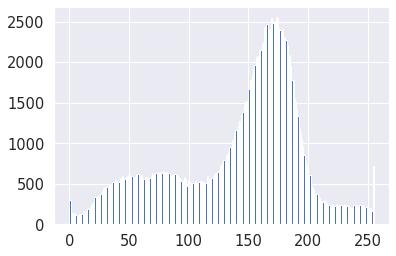

In [0]:
mat_img_autocontrast = np.array(img_autocontrast)
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(mat_img_autocontrast[0:,0:,0].flatten(), bins=range(256))
plt.show()

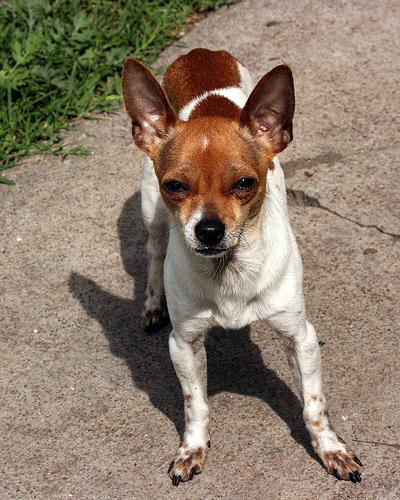

In [0]:
img_autocontrast

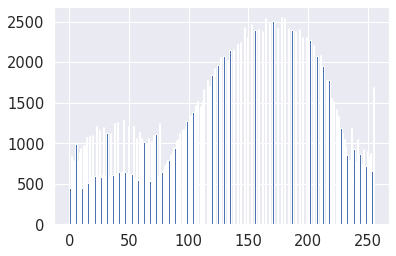

In [0]:

img_equalize = ImageOps.equalize(img)
mat_img_equalize = np.array(img_equalize)
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(mat_img_equalize[0:,0:,0].flatten(), 
                            bins=range(256))
plt.show()

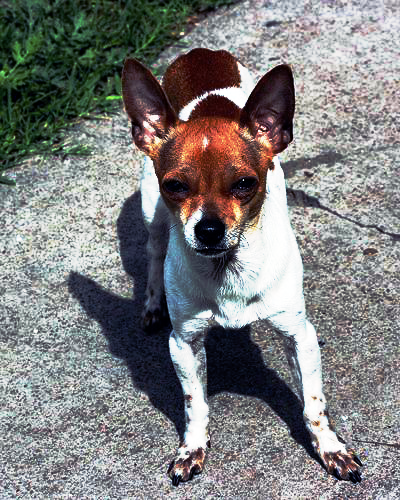

In [0]:
img_equalize

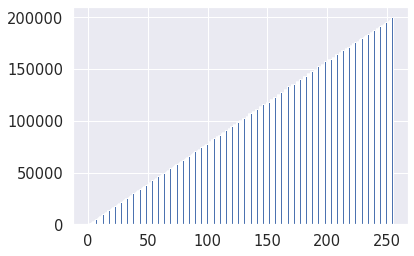

In [0]:
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(mat_img_equalize[0:,0:,0].flatten(), 
                            bins=range(256), cumulative=True)
plt.show()

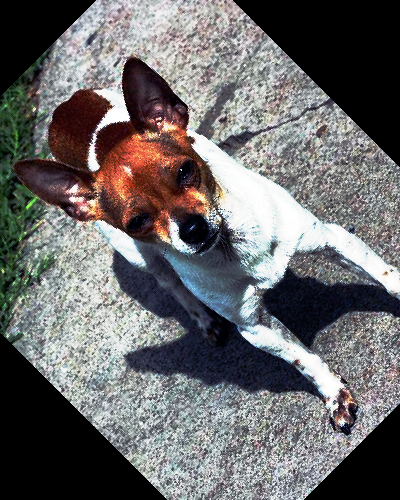

In [0]:
img_equalize.rotate(45, resample=0)

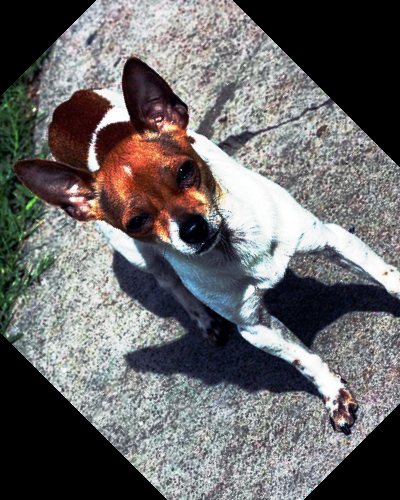

In [0]:
img_equalize.rotate(45, resample=Image.BILINEAR)

In [0]:
# Charger l'image sous forme d'une matrice de pixels
mat_img_equalize

# Générer le bruit gaussien de moyenne nulle et d'écart-type 7 (variance 49)
noise = np.random.normal(0, 7, mat_img_equalize[0:,0:,0].shape)
mat_img_equalize_noise = mat_img_equalize
mat_img_equalize_noise = mat_img_equalize_noise[0:,0:,0] + noise
# Créer l'image bruitée et l'afficher
noisy_img = Image.fromarray(mat_img_equalize_noise).convert('RGB')
noisy_img.show()

In [0]:
# Charger l'image sous forme d'une matrice de pixels
mat_img_equalize

# Générer le bruit gaussien de moyenne nulle et d'écart-type 7 (variance 49)
noise = np.random.normal(0, 7, mat_img_equalize[0:,0:,0].shape)
mat_img_equalize_noise = mat_img_equalize
mat_img_equalize_noise[0:,0:,0] = mat_img_equalize_noise[0:,0:,0] + noise
# Créer l'image bruitée et l'afficher
noisy_img = Image.fromarray(mat_img_equalize_noise).convert('RGB')
noisy_img.show()

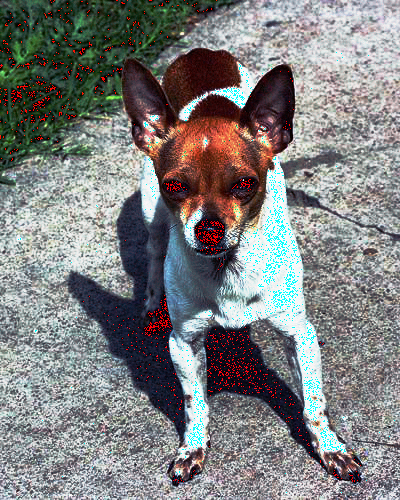

In [0]:
noisy_img

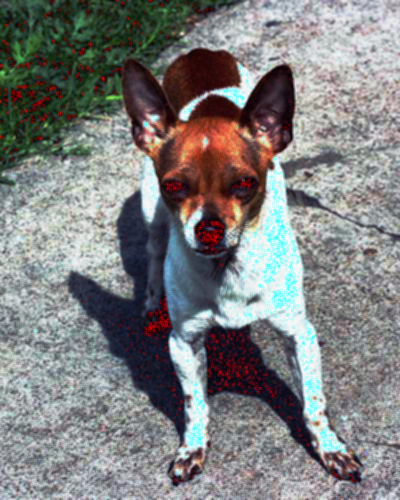

In [0]:
# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
noisy_img_blurbox = noisy_img.filter(ImageFilter.BoxBlur(1))
noisy_img_blurbox

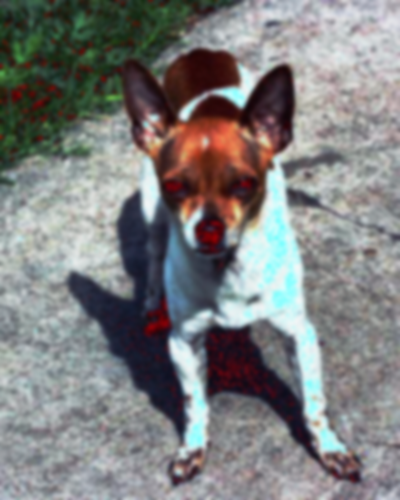

In [0]:
# GaussianBlur(radius)
noisy_img_GaussianBlur = noisy_img.filter(ImageFilter.GaussianBlur(2))
noisy_img_GaussianBlur

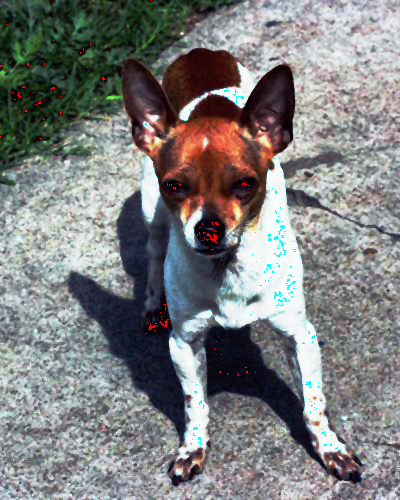

In [0]:
# MedianFilter
noisy_img_Median = noisy_img.filter(ImageFilter.MedianFilter(size=3))
noisy_img_Median

## Features Extraction  : SIFT

In [0]:
# decolorisation : gray
mat_img_gray = cv.cvtColor(np.array(img_equalize),cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(mat_img_gray, None)
mat_img_features = cv.drawKeypoints(mat_img_gray, kp, 
                                         np.array(img_equalize))
#cv.imwrite('sift_keypoints.jpg',img)

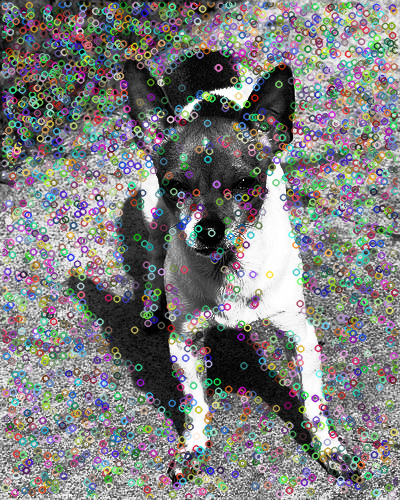

In [0]:
# Créer l'image et l'afficher
img_features = Image.fromarray(mat_img_features).convert('RGB')
img_features

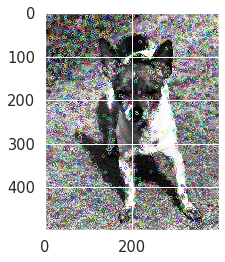

In [0]:
plt.figure()
plt.imshow(mat_img_features)
plt.show()

## Features Extraction  : SURF

In [0]:
# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
>>> surf = cv.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
>>> kp, des = surf.detectAndCompute(mat_img_gray, None)
>>> len(kp)

2159

In [0]:
# Check present Hessian threshold
print( surf.getHessianThreshold() )

400.0


In [0]:
# We set it to some 50000. Remember, it is just for representing in picture.
# In actual cases, it is better to have a value 300-500
surf.setHessianThreshold(12800)
# Again compute keypoints and check its number.
kp, des = surf.detectAndCompute(mat_img_gray, None)
print( len(kp) )

79


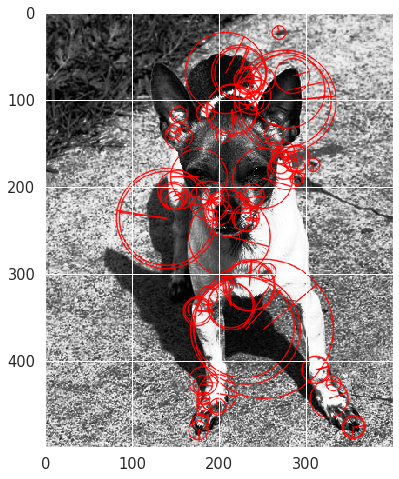

In [0]:
mat_img_gray_surf_feat = cv.drawKeypoints(mat_img_gray, kp, None, (255,0,0), 4)

fig = plt.figure(figsize=(8, 8))
plt.imshow(mat_img_gray_surf_feat)
plt.show()

## Descriptors from SURF
Finally we check the descriptor size and change it to 128 if it is only 64-dim.

In [0]:
# Find size of descriptor
print( surf.descriptorSize() )


64


In [0]:
# That means flag, "extended" is False.
surf.getExtended()

False

In [0]:
# So we make it to True to get 128-dim descriptors.
surf.setExtended(True)
kp, des = surf.detectAndCompute(mat_img_gray, None)
print( surf.descriptorSize() )

print( des.shape )


128
(79, 128)


## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only once
df_dogs = None

In [9]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     force_import=force_import, 
                                     path_train_list=path_train_list)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Loading from disk df_dogs...
Loading from disk X images...
Image matrix size :  (2097, 224, 224, 3)


filename                                               path  \
0  n02107683_1175.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
1  n02107683_1248.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
2  n02107683_1244.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
3  n02107683_1003.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
4  n02107683_1076.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   

                  breed class  Train  
0  Bernese_mountain_dog     0  False  
1  Bernese_mountain_dog     0   True  
2  Bernese_mountain_dog     0   True  
3  Bernese_mountain_dog     0  False  
4  Bernese_mountain_dog     0  False

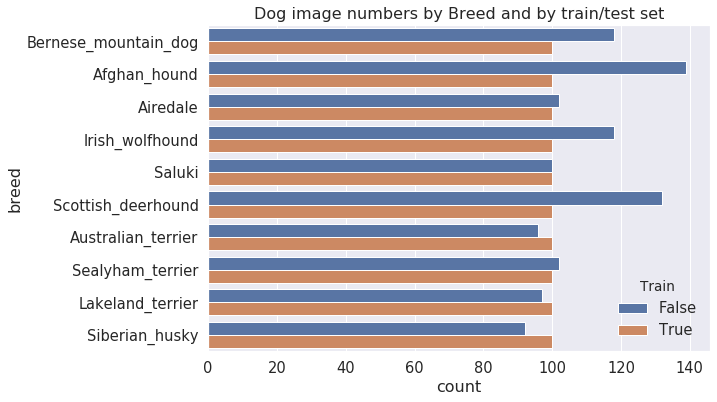

In [18]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## Keras : Use of VGG-16 pre-trained

In [31]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


#### Create features Train/Test

Need to re-create Y with 1000 classes

In [48]:
nb_breeds

3

In [23]:
list_Y_classes = get_imagenet_classes()
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, 
  X, list_X_classes=np.array(range(nb_breeds)),
  list_Y_classes=list_Y_classes)

print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 1000)
Y_test  (359, 1000)


#### Instance of neural network class

In [25]:
model = VGG16() # Création du modèle VGG-16 implementé par Keras
#model.get_weights()[-1][:10]
model.summary()





553467904/553467096 [==============================] - 12s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

#### Evaluate

In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = model.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = model.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [65]:
df_results = add_score(df_results, series_scores, model.name)
df_results

update line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


acc_test  acc_test_3B_0  acc_test_3B_1  acc_test_3B_2  \
VGG16_TL_class_01   0.974930            NaN            NaN            NaN   
my_VGG16_02         0.512563            NaN            NaN            NaN   
my_VGG16_03         0.440111            NaN            NaN            NaN   
my_VGG16_03_23filt  0.434540            NaN            NaN            NaN   
my_VGG16_03_24filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_25filt  0.428969            NaN            NaN            NaN   
my_VGG16_03_26filt  0.445682            NaN            NaN            NaN   
my_VGG16_03_27filt  0.409471            NaN            NaN            NaN   
my_VGG16_03_28filt  0.415042            NaN            NaN            NaN   
my_VGG16_03_29filt  0.484680            NaN            NaN            NaN   
my_VGG16_03_30filt  0.281337            NaN            NaN            NaN   
my_VGG16_03_31filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_32filt  0.479109            NaN            NaN            NaN   
my_VGG16_03_33filt  0.420613            NaN            NaN            NaN   
my_VGG16_03_34filt  0.498607            NaN            NaN            NaN   
my_VGG16_03_35filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_36filt  0.437326            NaN            NaN            NaN   
my_VGG16_03_37filt  0.454039            NaN            NaN            NaN   
my_VGG16_03_38filt  0.487465            NaN            NaN            NaN   
my_VGG16_03_39filt  0.459610            NaN            NaN            NaN   
my_VGG16_03_40filt  0.456825            NaN            NaN            NaN   
my_VGG16_03_41filt  0.459610            NaN            NaN            NaN   
my_VGG16_03_42filt  0.442897            NaN            NaN            NaN   
my_VGG16_03_43filt  0.493036            NaN            NaN            NaN   
my_VGG16_03_44filt  0.490251            NaN            NaN            NaN   
my_VGG16_03_45filt  0.470752            NaN            NaN            NaN   
my_VGG16_03_46filt  0.454039            NaN            NaN            NaN   
my_VGG16_03_47filt  0.484680            NaN            NaN            NaN   
my_VGG16_03_48filt  0.470752            NaN            NaN            NaN   
my_VGG16_03_49filt  0.445682            NaN            NaN            NaN   
my_VGG16_03_50filt  0.481894            NaN            NaN            NaN   
my_VGG16_03_51filt  0.440111            NaN            NaN            NaN   
my_VGG16_03_52filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_53filt  0.462396            NaN            NaN            NaN   
my_VGG16_03_54filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_55filt  0.520891            NaN            NaN            NaN   
my_VGG16_03_56filt  0.476323            NaN            NaN            NaN   
my_VGG16_03_57filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_58filt  0.448468            NaN            NaN            NaN   
my_VGG16_03_59filt  0.409471            NaN            NaN            NaN   
my_VGG16_03_60filt  0.442897            NaN            NaN            NaN   
my_VGG16_03_61filt  0.415042            NaN            NaN            NaN   
my_VGG16_03_62filt  0.479109            NaN            NaN            NaN   
my_VGG16_03_63filt  0.493036            NaN            NaN            NaN   
vgg16               0.885794       0.940678       0.863309       0.852941   

                    acc_train       t_fit    t_pred  
VGG16_TL_class_01    0.990000   11.906220  1.757683  
my_VGG16_02          1.000000   12.295422  0.835936  
my_VGG16_03          0.866667   13.711606  0.724172  
my_VGG16_03_23filt   0.923333   92.847607  1.958368  
my_VGG16_03_24filt   0.926667   91.096862  1.910622  
my_VGG16_03_25filt   0.903333   96.885097  2.049942  
my_VGG16_03_26filt   0.630000  101.970747  2.054569  
my_VGG16_03_27filt   0.890000  104.395885  2.

In [66]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### Predict from images

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1175.jpg
40960/35363 [==================================] - 0s 0us/step
VGG-16 : Top 3 : [('n02107683', 'Bernese_mountain_dog', 0.8732384), ('n02107908', 'Appenzeller', 0.0436079), ('n02108000', 'EntleBucher', 0.02318491)]
[('n02107683', 'Bernese_mountain_dog', 0.8732384), ('n02107908', 'Appenzeller', 0.0436079), ('n02108000', 'EntleBucher', 0.02318491)]


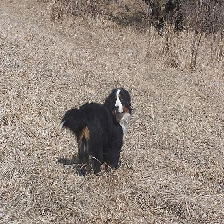

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
VGG-16 : Top 3 : [('n02107683', 'Bernese_mountain_dog', 0.97569275), ('n02107908', 'Appenzeller', 0.017292695), ('n02108000', 'EntleBucher', 0.004781216)]
[('n02107683', 'Bernese_mountain_dog', 0.97569275), ('n02107908', 'Appenzeller', 0.017292695), ('n02108000', 'EntleBucher', 0.004781216)]


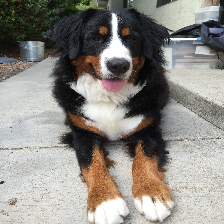

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
VGG-16 : Top 3 : [('n02088094', 'Afghan_hound', 0.9959006), ('n02105251', 'briard', 0.0018045893), ('n02097474', 'Tibetan_terrier', 0.0016100357)]
[('n02088094', 'Afghan_hound', 0.9959006), ('n02105251', 'briard', 0.0018045893), ('n02097474', 'Tibetan_terrier', 0.0016100357)]


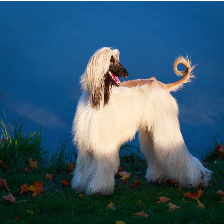

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
VGG-16 : Top 3 : [('n02096051', 'Airedale', 0.56952333), ('n02091635', 'otterhound', 0.3059206), ('n02093991', 'Irish_terrier', 0.066529915)]
[('n02096051', 'Airedale', 0.56952333), ('n02091635', 'otterhound', 0.3059206), ('n02093991', 'Irish_terrier', 0.066529915)]


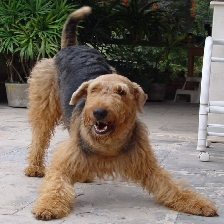

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, model)
img_raw

## Transfer Learning with Keras

### Stratégie #2 : extraction de features

#### Load data

In [0]:
df_dogs, X, dict_breed = import_data(paths_images_breeds, 
                                     train_percent=train_percent, 
                                     force_import=False)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Image matrix size :  (2097, 224, 224, 3)


filename                                               path  \
0  n02107683_1175.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
1  n02107683_1248.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
2  n02107683_1244.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
3  n02107683_1003.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
4  n02107683_1076.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   

                  breed class  Train  Train_2    OK  
0  Bernese_mountain_dog     0   True    False  True  
1  Bernese_mountain_dog     0  False     True  True  
2  Bernese_mountain_dog     0   True     True  True  
3  Bernese_mountain_dog     0   True    False  True  
4  Bernese_mountain_dog     0   True    False  True

In [0]:
dict_breed

{0: 'Bernese_mountain_dog', 1: 'Afghan_hound', 2: 'Airedale'}

#### Create features

In [69]:
nb_breeds

3

In [70]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 3)
Y_test  (359, 3)


In [139]:
list_Y_classes = list(dict_breed.values())[:nb_breeds]
list_Y_classes

['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

#### Create model

In [104]:
#### Load VGG16 model without FC layers

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model_trans = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# we don't train layers 
for layer in model_trans.layers:
   layer.trainable = False

#### Prepare new layers

# Récupérer la sortie de ce réseau
x = model_trans.output
flatten = Flatten()(x)
# Ajouter la nouvelle couche fully-connected pour la classification à 3 classes
predictions = Dense(nb_breeds, activation='softmax')(flatten)

#### Update Model

# Définir le nouveau modèle
new_model_2 = Model(inputs=model_trans.input, outputs=predictions)
new_model_2.name = name_new_model_2

new_model_2.summary()

Model: "VGG16_TL_class_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128) 

#### Train

Train on 300 samples, validate on 359 samples
Epoch 1/30
 - 2s - loss: 2.7723 - acc: 0.7833 - val_loss: 0.5845 - val_acc: 0.9610
Epoch 2/30
 - 2s - loss: 0.6602 - acc: 0.9500 - val_loss: 0.3667 - val_acc: 0.9749
Epoch 3/30
 - 2s - loss: 0.4005 - acc: 0.9700 - val_loss: 0.5154 - val_acc: 0.9610
Epoch 4/30
 - 2s - loss: 0.4550 - acc: 0.9667 - val_loss: 0.7735 - val_acc: 0.9443
Epoch 5/30
 - 2s - loss: 0.3967 - acc: 0.9700 - val_loss: 0.4413 - val_acc: 0.9666
Epoch 6/30
 - 2s - loss: 0.5858 - acc: 0.9633 - val_loss: 0.9639 - val_acc: 0.9304
Epoch 7/30
 - 2s - loss: 0.6777 - acc: 0.9533 - val_loss: 0.3768 - val_acc: 0.9721
Epoch 8/30
 - 2s - loss: 0.3309 - acc: 0.9767 - val_loss: 0.2319 - val_acc: 0.9833
Epoch 9/30
 - 2s - loss: 0.2916 - acc: 0.9767 - val_loss: 0.4661 - val_acc: 0.9638
Epoch 10/30
 - 2s - loss: 0.3807 - acc: 0.9733 - val_loss: 0.7429 - val_acc: 0.9499
Epoch 11/30
 - 2s - loss: 0.3307 - acc: 0.9767 - val_loss: 0.2080 - val_acc: 0.9861
Epoch 12/30
 - 2s - loss: 0.2149 - acc:

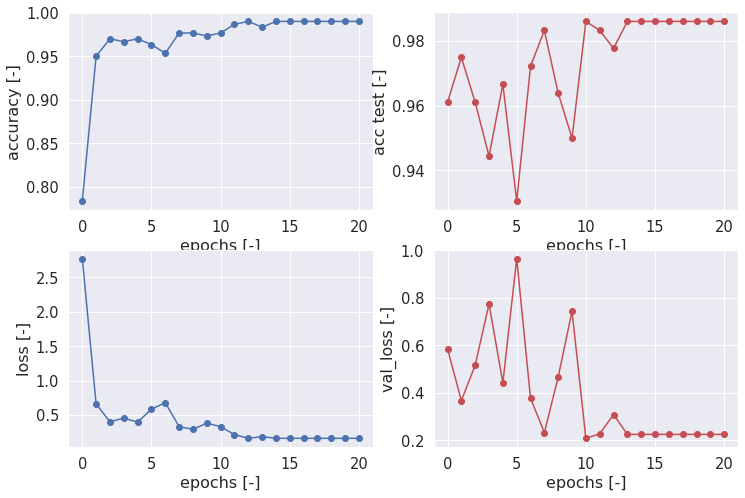

In [107]:
# Compiler le modèle 
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 

new_model_2.compile(loss="categorical_crossentropy", 
                  optimizer=sgd_2, 
                  metrics=["accuracy"])
# Entraîner sur les données d'entraînement (X_train, y_train)
#Epoch 10/450 - 1s - loss: 0.2803 - acc: 0.9826
epochs = 30
batch_size = None
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=10,
                                   restore_best_weights=True)
t_fit_0 = time.time()
model_info = new_model_2.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test),
                             callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#### Save model

In [108]:
# save
joblib.dump(new_model_2, path_model_2, compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/VGG16_TL_class_01.pkl']

#### Evaluate

In [67]:
print("Loading from disk new_model_2...")
new_model_2 = joblib.load(path_model_2)

Loading from disk new_model_2...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
Y_train.shape

(300, 3)

In [114]:
score_train = new_model_2.evaluate(X_train, Y_train, batch_size=16)
score_train

300/300 [==============================] - 1s 3ms/step


[0.2686350361506256, 0.9833333333333333]

In [115]:
score_test = new_model_2.evaluate(X_test, Y_test, batch_size=16)
score_test

359/359 [==============================] - 1s 3ms/step


[0.20795290042134126, 0.9860724233983287]

In [111]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = new_model_2.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = new_model_2.predict(X_test)
t_pred_3 = time.time()

In [136]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

[0, 1, 2]


In [137]:
df_results = add_score(df_results, series_scores, new_model_2.name)
df_results

update line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


acc_test  acc_test_3B_0  acc_test_3B_1  acc_test_3B_2  \
my_VGG16_02         0.512563            NaN            NaN            NaN   
my_VGG16_03         0.440111            NaN            NaN            NaN   
my_VGG16_03_23filt  0.434540            NaN            NaN            NaN   
my_VGG16_03_24filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_25filt  0.428969            NaN            NaN            NaN   
my_VGG16_03_26filt  0.445682            NaN            NaN            NaN   
my_VGG16_03_27filt  0.409471            NaN            NaN            NaN   
my_VGG16_03_28filt  0.415042            NaN            NaN            NaN   
my_VGG16_03_29filt  0.484680            NaN            NaN            NaN   
my_VGG16_03_30filt  0.281337            NaN            NaN            NaN   
my_VGG16_03_31filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_32filt  0.479109            NaN            NaN            NaN   
my_VGG16_03_33filt  0.420613            NaN            NaN            NaN   
my_VGG16_03_34filt  0.498607            NaN            NaN            NaN   
my_VGG16_03_35filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_36filt  0.437326            NaN            NaN            NaN   
my_VGG16_03_37filt  0.454039            NaN            NaN            NaN   
my_VGG16_03_38filt  0.487465            NaN            NaN            NaN   
my_VGG16_03_39filt  0.459610            NaN            NaN            NaN   
my_VGG16_03_40filt  0.456825            NaN            NaN            NaN   
my_VGG16_03_41filt  0.459610            NaN            NaN            NaN   
my_VGG16_03_42filt  0.442897            NaN            NaN            NaN   
my_VGG16_03_43filt  0.493036            NaN            NaN            NaN   
my_VGG16_03_44filt  0.490251            NaN            NaN            NaN   
my_VGG16_03_45filt  0.470752            NaN            NaN            NaN   
my_VGG16_03_46filt  0.454039            NaN            NaN            NaN   
my_VGG16_03_47filt  0.484680            NaN            NaN            NaN   
my_VGG16_03_48filt  0.470752            NaN            NaN            NaN   
my_VGG16_03_49filt  0.445682            NaN            NaN            NaN   
my_VGG16_03_50filt  0.481894            NaN            NaN            NaN   
my_VGG16_03_51filt  0.440111            NaN            NaN            NaN   
my_VGG16_03_52filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_53filt  0.462396            NaN            NaN            NaN   
my_VGG16_03_54filt  0.465181            NaN            NaN            NaN   
my_VGG16_03_55filt  0.520891            NaN            NaN            NaN   
my_VGG16_03_56filt  0.476323            NaN            NaN            NaN   
my_VGG16_03_57filt  0.467967            NaN            NaN            NaN   
my_VGG16_03_58filt  0.448468            NaN            NaN            NaN   
my_VGG16_03_59filt  0.409471            NaN            NaN            NaN   
my_VGG16_03_60filt  0.442897            NaN            NaN            NaN   
my_VGG16_03_61filt  0.415042            NaN            NaN            NaN   
my_VGG16_03_62filt  0.479109            NaN            NaN            NaN   
my_VGG16_03_63filt  0.493036            NaN            NaN            NaN   
vgg16               0.885794       0.940678       0.863309       0.852941   
VGG16_TL_class_01   0.986072       1.000000       0.971223       0.990196   

                    acc_train       t_fit    t_pred  
my_VGG16_02          1.000000   12.295422  0.835936  
my_VGG16_03          0.866667   13.711606  0.724172  
my_VGG16_03_23filt   0.923333   92.847607  1.958368  
my_VGG16_03_24filt   0.926667   91.096862  1.910622  
my_VGG16_03_25filt   0.903333   96.885097  2.049942  
my_VGG16_03_26filt   0.630000  101.970747  2.054569  
my_VGG16_03_27filt   0.890000  104.395885  2.138115  
my_VGG16_03_28filt   0.850000  106.155934  2.

In [140]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### Compare

In [142]:
model.name

'vgg16'

In [143]:
new_model_2.name

'VGG16_TL_class_01'

In [147]:
df_res = df_results.filter(items=[model.name, new_model_2.name], axis=0)
df_res

acc_test  acc_test_3B_0  acc_test_3B_1  acc_test_3B_2  \
vgg16              0.885794       0.940678       0.863309       0.852941   
VGG16_TL_class_01  0.986072       1.000000       0.971223       0.990196   

                   acc_train      t_fit    t_pred  
vgg16               0.883333   0.000000  6.288219  
VGG16_TL_class_01   0.983333  36.452183  1.886233

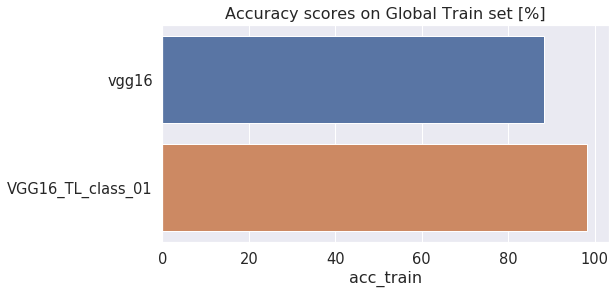

In [149]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_train").index,
    x=100*df_res.sort_values(by="acc_train")["acc_train"], orient="h")

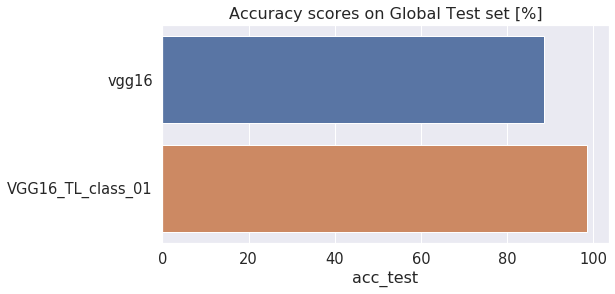

In [150]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_test").index,
    x=100*df_res.sort_values(by="acc_test")["acc_test"], orient="h")

Text(0.5, 0, 'acc_test [%]')

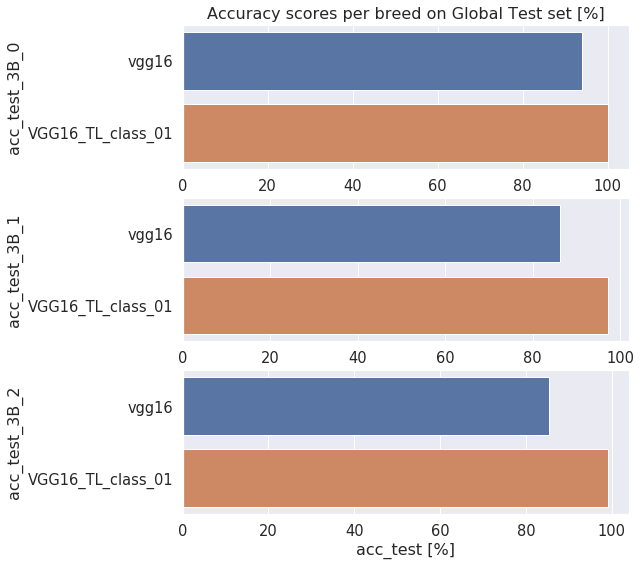

In [167]:
# plot Accuracy scores per breed on Global Test set
fig = plt.figure(figsize=(8, 9))
ax1 = fig.add_subplot(3,1,1)
sns.barplot(ax=ax1, y=df_res.index,
    x=100*df_res["acc_test_3B_0"], orient="h")
ax1.set_title("Accuracy scores per breed on Global Test set [%]")
ax1.set_ylabel('acc_test_3B_0')
ax2 = fig.add_subplot(3,1,2)
sns.barplot(ax=ax2, y=df_res.index,
    x=100*df_res["acc_test_3B_1"], orient="h")
ax2.set_ylabel('acc_test_3B_1')
ax3 = fig.add_subplot(3,1,3)
sns.barplot(ax=ax3, y=df_res.index,
    x=100*df_res["acc_test_3B_2"], orient="h")
ax3.set_ylabel('acc_test_3B_2')
ax3.set_xlabel('acc_test [%]')


#### Predict

Try to predict picture 

##### Load model

In [0]:
new_model_2 = joblib.load(path_model_2)

##### Predict from image

In [0]:
dict_breed

{0: 'Bernese_mountain_dog', 1: 'Afghan_hound', 2: 'Airedale'}

from data set :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1248.jpg
Probabilities :  [[1. 0. 0.]]
Bernese_mountain_dog


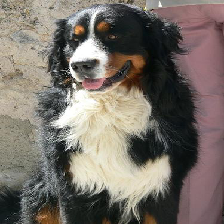

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
Probabilities :  [[1. 0. 0.]]
Bernese_mountain_dog


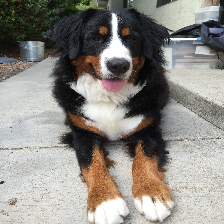

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
Probabilities :  [[0. 1. 0.]]
Afghan_hound


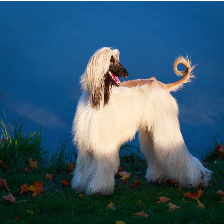

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
Probabilities :  [[0. 0. 1.]]
Airedale


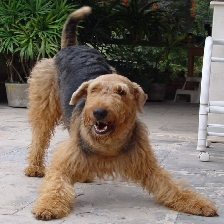

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, new_model_2)
img_raw